In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import load_allen, make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
from register.register import *
from register.register import _load_prepare_ants

In [3]:
cfg = Config()
allen = load_allen()

In [4]:
os.listdir(cfg.base_dir)

[
    'Atlas2014_LPS_sm_Symmetric_N162_0.20.grd',
    'processed',
    'structure_315.nrrd',
    '_label_names.rtf',
    'Symmetric_N162_0.275.nii.gz',
    'N162_medium_symm_0.1.nii.gz',
    'Symmetric_N162_0.10.nii.gz',
    'Symmetric_N162_0.20.nii.gz',
    'N162_CCF.nii.gz',
    'N162_finesc_symm_0.1.nii.gz',
    'iso_nib.nii.gz',
    'mouseatlas_2020.json',
    'N162_medium_symm_0.2.nii.gz',
    'iso_inverted.nii.gz',
    'N162_finesc_symm_0.2.nii.gz',
    'Symmetric_N162_0.05.nii.gz',
    'Inverse_Atlas2014_LPS_sm_Symmetric_N162_0.20.grd',
    'iso_ants.nii.gz',
    'Inverse_Atlas2014_LPS_sm_Symmetric_N162_0.10.grd',
    'Atlas2014_LPS_sm_Symmetric_N162_0.10.grd',
    'N162_coarse_symm_0.2.nii.gz',
    'atlases_templates'
]

In [5]:
ref_file = pjoin(cfg.base_dir, '_N162_CCF.nii.gz')
N162_CCF_nib = nib.load(ref_file)
N162_CCF_ants = ants.image_read(ref_file)
N162_CCF_ants

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (118, 90, 160)
         Spacing    : (0.1, 0.1, 0.1)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [6]:
in_house_name = 'Symmetric_N162'
resolution = 200
spacing_mm = resolution / 1000

yale_file = f"{in_house_name}_{spacing_mm:.2f}.nii.gz"
yale_file = pjoin(cfg.base_dir, yale_file)

yale = _load_prepare_ants(yale_file, spacing_mm)
yale_raw = reset_ants_img(
    img=ants.image_read(yale_file),
    origin=N162_CCF_ants.origin,
    spacing=spacing_mm,
)

template = reset_ants_img(
    img=allen['template'].astype('uint32'),
    spacing=0.1,
)

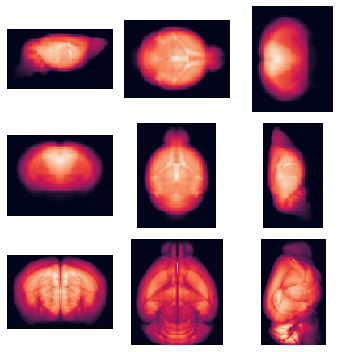

In [7]:
fig, axes = create_figure(3, 3, (5, 5))
for i in range(3):
    axes[0, i].imshow(yale_raw.mean(i))
    axes[1, i].imshow(yale.mean(i))
    axes[2, i].imshow(template.mean(i))
remove_ticks(axes)

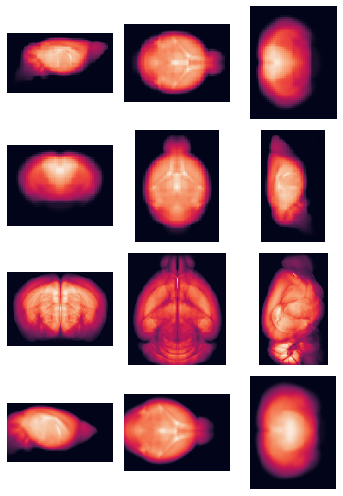

In [11]:
fig, axes = create_figure(4, 3, (5, 7))
for i in range(3):
    axes[0, i].imshow(yale_raw.mean(i))
    axes[1, i].imshow(yale.mean(i))
    axes[2, i].imshow(template.mean(i))
    axes[3, i].imshow(N162_CCF_ants.mean(i))
remove_ticks(axes)

In [20]:
medium = nib.load(pjoin(cfg.base_dir, f'N162_medium_symm_{0.1}.nii.gz'))
medium

<nibabel.nifti1.Nifti1Image object at 0x7f5a56289760>

In [21]:
iso = allen['isocortex_mask'].copy()
iso = reorient_arr(iso)
iso = iso[..., ::-1]

In [22]:
iso_nib = nib.Nifti1Image(
    dataobj=iso.astype(medium.get_data_dtype()),
    affine=medium.affine,
    header=medium.header,
)
nib.save(iso_nib, pjoin(cfg.base_dir, 'iso_nib.nii.gz'))

In [23]:
iso_nib.affine

array([[-0.1,  0. ,  0. ,  0. ],
       [ 0. , -0.1,  0. ,  0. ],
       [ 0. ,  0. ,  0.1,  0. ],
       [ 0. ,  0. ,  0. ,  1. ]])

In [24]:
medium.affine

array([[-0.1,  0. ,  0. ,  0. ],
       [ 0. , -0.1,  0. ,  0. ],
       [ 0. ,  0. ,  0.1,  0. ],
       [ 0. ,  0. ,  0. ,  1. ]])

In [25]:
coarse = nib.load(pjoin(cfg.base_dir, f'N162_coarse_symm_{0.2}.nii.gz'))

In [39]:
iso_n162_coarse = (np.logical_or(
    coarse.get_fdata() == 1,
    coarse.get_fdata() == 101
)).astype('uint32')
iso_n162_coarse = nib.Nifti1Image(
    dataobj=iso_n162_coarse,
    affine=coarse.affine,
    header=coarse.header,
)
nib.save(iso_n162_coarse, pjoin(cfg.base_dir, f'test.nii.gz'))

<matplotlib.image.AxesImage object at 0x7f5a4fefe670>

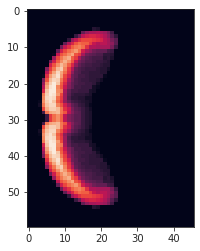

In [38]:
plt.imshow(iso_n162_coarse.get_fdata().mean(2))

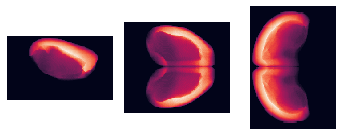

In [36]:
fig, axes = create_figure(1, 3, (5, 2), reshape=True)
for i in range(3):
    axes[0, i].imshow(iso.mean(i))
remove_ticks(axes)

In [37]:
ants.image_write(iso, pjoin(cfg.base_dir, 'iso_ants.nii.gz'))

In [17]:
iso_inverted = ants.image_read(pjoin(cfg.base_dir, 'iso_inverted.nii.gz'))
iso_inverted

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (118, 90, 160)
         Spacing    : (0.1, 0.1, 0.1)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

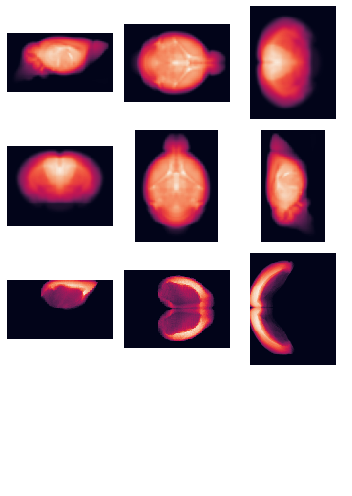

In [18]:
fig, axes = create_figure(4, 3, (5, 7))
for i in range(3):
    axes[0, i].imshow(yale_raw.mean(i))
    axes[1, i].imshow(yale.mean(i))
    axes[2, i].imshow(iso_inverted.mean(i))
remove_ticks(axes)

In [19]:
yale_raw

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (118, 90, 160)
         Spacing    : (0.1, 0.1, 0.1)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [20]:
iso_inverted

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (118, 90, 160)
         Spacing    : (0.1, 0.1, 0.1)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

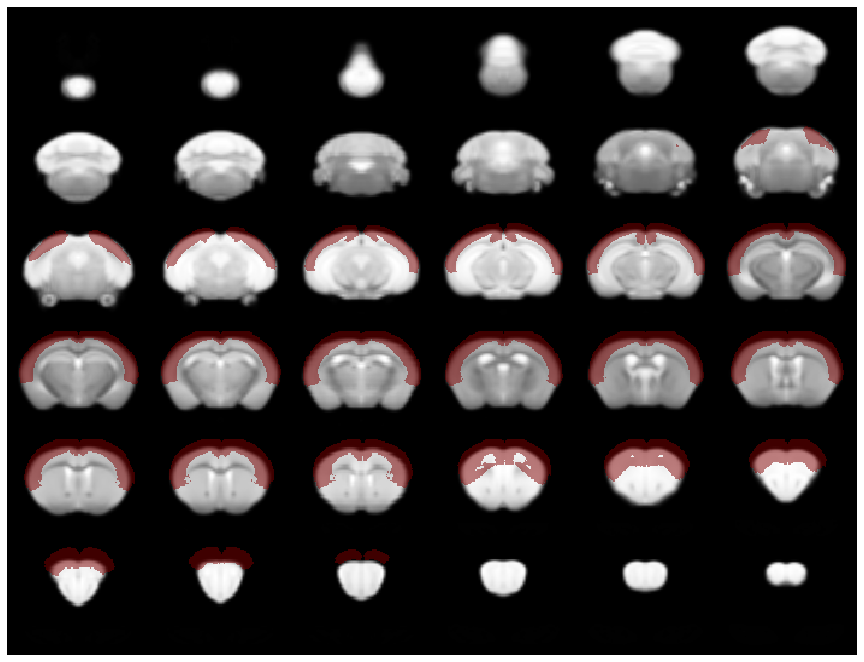

In [25]:
yale_raw.plot(
    overlay=iso_inverted,
    axis=2,
    nslices=36,
    overlay_alpha=0.5,
)

In [27]:
test = ants.image_read(pjoin(cfg.base_dir, 'N162_in_Atlas2014_LPS.nii.gz'))
test

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (456, 320, 528)
         Spacing    : (0.025, 0.025, 0.025)
         Origin     : (5.78, 7.83, -6.93)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [31]:
yale_raw

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (118, 90, 160)
         Spacing    : (0.1, 0.1, 0.1)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [32]:
[x * 4 for x in (118, 90, 160)]

[472, 360, 640]